In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

from tensorflow.keras.preprocessing import image_dataset_from_directory

In [2]:
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
path_to_zip = tf.keras.utils.get_file('cats_and_dogs.zip', origin=_URL, extract=True)
PATH = os.path.join(os.path.dirname(path_to_zip), 'cats_and_dogs_filtered')

train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')

BATCH_SIZE = 32
IMG_SIZE = (160, 160)

train_dataset = image_dataset_from_directory(train_dir,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE)

Found 2000 files belonging to 2 classes.


In [3]:
validation_dataset = image_dataset_from_directory(validation_dir,
                                                  shuffle=True,
                                                  batch_size=BATCH_SIZE,
                                                  image_size=IMG_SIZE)

Found 1000 files belonging to 2 classes.


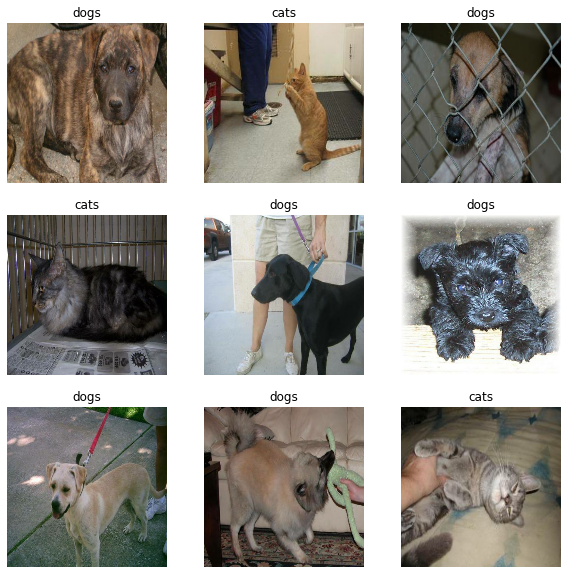

In [4]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [5]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)

print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 26
Number of test batches: 6


In [6]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

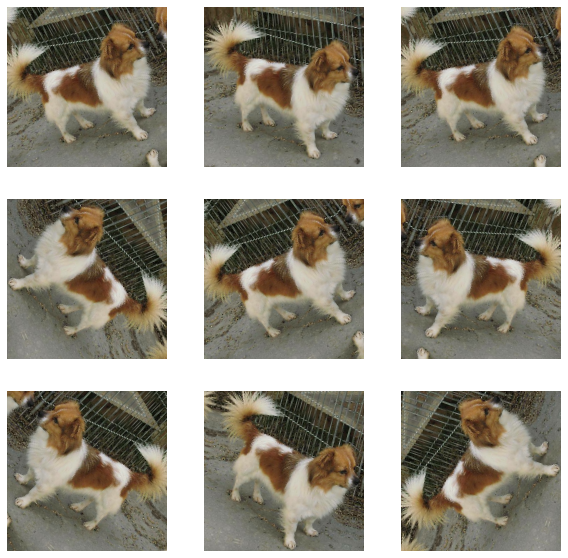

In [7]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])

for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

In [8]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
rescale = tf.keras.layers.experimental.preprocessing.Rescaling(1./127.5, offset= -1)

In [9]:
# Create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 5, 5, 1280)


In [10]:
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 80, 80, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 80, 80, 32)   128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 80, 80, 32)   0           bn_Conv1[0][0]                   
_______________________________________________________________________________

In [11]:
base_model.trainable = False

global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


In [12]:
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1)


In [13]:
inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.subtract (TFOpLambda (None, 160, 160, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_160 (Functi (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0     

In [14]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

len(model.trainable_variables)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


2

In [15]:
initial_epochs = 10

loss0, accuracy0 = model.evaluate(validation_dataset)

26/26 [==============================] - 3s 43ms/step - loss: 0.6259 - accuracy: 0.6064


In [16]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 0.63
initial accuracy: 0.61


In [17]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

model_before = model

Epoch 1/10
63/63 [==============================] - 7s 64ms/step - loss: 0.6037 - accuracy: 0.6460 - val_loss: 0.4309 - val_accuracy: 0.8045
Epoch 2/10
63/63 [==============================] - 4s 60ms/step - loss: 0.4496 - accuracy: 0.7600 - val_loss: 0.3164 - val_accuracy: 0.8911
Epoch 3/10
63/63 [==============================] - 4s 60ms/step - loss: 0.3778 - accuracy: 0.8195 - val_loss: 0.2530 - val_accuracy: 0.9208
Epoch 4/10
63/63 [==============================] - 4s 60ms/step - loss: 0.3139 - accuracy: 0.8645 - val_loss: 0.2026 - val_accuracy: 0.9356
Epoch 5/10
63/63 [==============================] - 4s 61ms/step - loss: 0.2798 - accuracy: 0.8820 - val_loss: 0.1797 - val_accuracy: 0.9418
Epoch 6/10
63/63 [==============================] - 4s 60ms/step - loss: 0.2478 - accuracy: 0.8960 - val_loss: 0.1658 - val_accuracy: 0.9468
Epoch 7/10
63/63 [==============================] - 4s 60ms/step - loss: 0.2304 - accuracy: 0.9005 - val_loss: 0.1485 - val_accuracy: 0.9530
Epoch 8/10
63

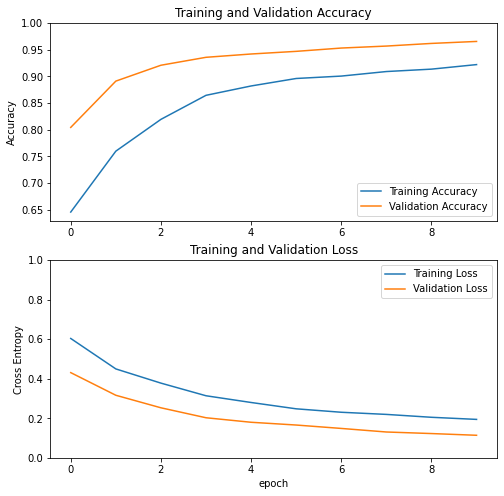

In [18]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [19]:
base_model.trainable = True

In [20]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

Number of layers in the base model:  154


In [21]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(lr=base_learning_rate/10),
              metrics=['accuracy'])

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.subtract (TFOpLambda (None, 160, 160, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_160 (Functi (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0     

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [22]:
len(model.trainable_variables)

56

In [23]:
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)

Epoch 10/20
63/63 [==============================] - 10s 81ms/step - loss: 0.1548 - accuracy: 0.9350 - val_loss: 0.0630 - val_accuracy: 0.9802
Epoch 11/20
63/63 [==============================] - 5s 71ms/step - loss: 0.1227 - accuracy: 0.9475 - val_loss: 0.0530 - val_accuracy: 0.9802
Epoch 12/20
63/63 [==============================] - 5s 69ms/step - loss: 0.0984 - accuracy: 0.9575 - val_loss: 0.0602 - val_accuracy: 0.9790
Epoch 13/20
63/63 [==============================] - 5s 68ms/step - loss: 0.1006 - accuracy: 0.9615 - val_loss: 0.0459 - val_accuracy: 0.9802
Epoch 14/20
63/63 [==============================] - 4s 67ms/step - loss: 0.0953 - accuracy: 0.9640 - val_loss: 0.0468 - val_accuracy: 0.9839
Epoch 15/20
63/63 [==============================] - 5s 68ms/step - loss: 0.0843 - accuracy: 0.9670 - val_loss: 0.0721 - val_accuracy: 0.9728
Epoch 16/20
63/63 [==============================] - 5s 70ms/step - loss: 0.0808 - accuracy: 0.9685 - val_loss: 0.0442 - val_accuracy: 0.9839
Epoch

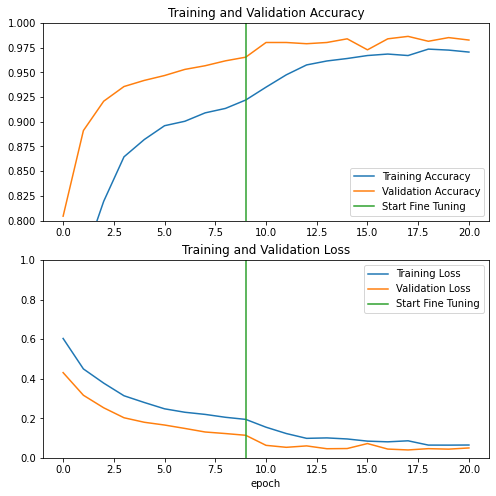

In [24]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [25]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

6/6 [==============================] - 1s 45ms/step - loss: 0.0268 - accuracy: 0.9896
Test accuracy : 0.9895833134651184


Predictions Before:
 [1 0 0 0 1 0 0 0 1 0 0 1 0 0 1 1 0 1 1 1 1 1 0 0 1 0 0 0 0 0 0 1]
Predictions After:
 [1 0 0 0 1 0 0 0 1 0 0 1 0 0 1 1 0 1 1 1 1 1 0 0 1 0 0 0 0 0 0 1]
Labels:
 [1 0 1 0 1 0 0 0 1 0 0 1 0 0 1 1 0 1 1 1 1 1 0 0 1 0 0 0 0 0 0 1]


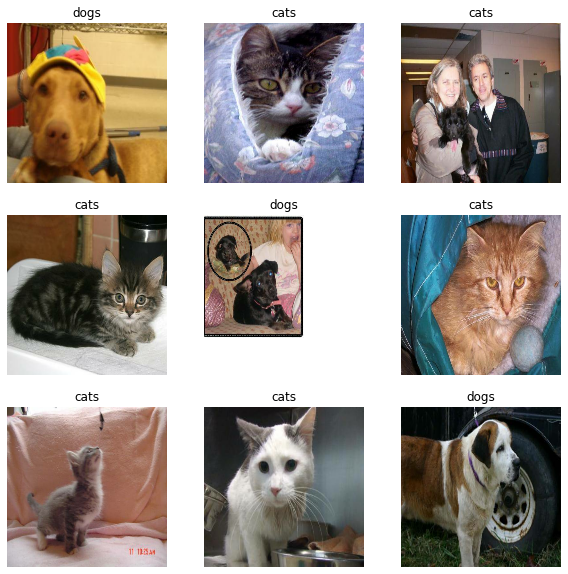

In [29]:
#Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions_before = model_before.predict_on_batch(image_batch).flatten()
predictions = model.predict_on_batch(image_batch).flatten()

# Apply a sigmoid since our model returns logits
predictions_before = tf.nn.sigmoid(predictions_before)
predictions_before = tf.where(predictions_before < 0.5, 0, 1)
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions Before:\n', predictions_before.numpy())
print('Predictions After:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")